In [2]:
# import pandas as pd
# import os
# import glob
# import concurrent.futures
# import time

# directory = 'C:\\Users\\minhtriet.pham\\Desktop\\Data Invoice 20230327\\NAM 2023\\Month 2'
# directory2 = 'C:\\Users\\minhtriet.pham\\Desktop\\Data Invoice 20230327\\NAM 2023\\Month 2'
# cate_dir = 'C:\\Users\\minhtriet.pham\\Desktop\\DataCate.xlsx'
# cate_dir2 = 'C:\\Users\\minhtriet.pham\\Desktop\\DataCate.xlsx'

# list of Excel files to read data from
# if os.path.exists(os.path.join(directory, '230201 Payment Summary - 2023-01-31T145747.301.xlsx')):
#     excel_files = glob.glob(os.path.join(directory, '*.xlsx'))
# else:
#     excel_files = glob.glob(os.path.join(directory2, '*.xlsx'))
# try:
#     use cols 0, Barcode; 2, Category Name
#     df2 = pd.read_excel(cate_dir, sheet_name='Sheet1', usecols=[0,2])
#     use cols 0, Barcode; 3, SubCategory Name
#     df2 = pd.read_excel(cate_dir, sheet_name='Sheet1', usecols=[0,3])
#     pass
# except FileNotFoundError:
#     df2 = pd.read_excel(cate_dir2, sheet_name='Sheet1', usecols=[0,2])
#     use cols 0, Barcode; 3, SubCategory Name
#     df2 = pd.read_excel(cate_dir2, sheet_name='Sheet1', usecols=[0,3])
#     pass

# outputfile =  'dataM1.csv'
# def excel2csv
# def excel2csv(inputfile, outputfile):
    
#     Check if exist file_path
#     if not os.path.exists(outputfile):
#         with open(outputfile, 'w') as f:
#             pass

#     Read the first line of the file
#     with open(outputfile, 'r') as f:
#         first_line = f.readline().strip()
#     Check if the first line contains the expected column names
#     has_headers = 'InvoiceID' in first_line
#     df = pd.read_excel(inputfile, sheet_name='Sheet2', skiprows=2, usecols=[4,7,8,14])
#     df2 Category
    
#     merge with Category, on "Barcode"
#     df = df.merge(df2, on='Barcode', how='left')
    
#     Check if the first line contains the expected column names
#     df.to_csv(outputfile, mode='a', header= not has_headers, index=False)


# loop through the list of Excel files
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     [executor.submit(excel2csv, file, outputfile) for file in excel_files]
#     for file in excel_files:
#         executor.submit(excel2csv,file)

In [3]:
import pandas as pd

# Sample data
dtypes = {'InvoiceID': str, 'Barcode': str, 'Sum of Qty': str, 'Total Exclude VAT': str, 'SubCategory Name': str}
df = pd.read_csv('dataM1.csv', dtype=dtypes)

df['Sum of Qty'] = pd.to_numeric(df['Sum of Qty'], errors='coerce').fillna(0).astype(int)
df['Total Exclude VAT'] = pd.to_numeric(df['Total Exclude VAT'], errors='coerce').fillna(0).astype(float)
df['SubCategory Name'] = df['SubCategory Name'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333854 entries, 0 to 333853
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   InvoiceID          333854 non-null  object 
 1   Barcode            333854 non-null  object 
 2   Sum of Qty         333854 non-null  int32  
 3   Total Exclude VAT  333854 non-null  float64
 4   SubCategory Name   333854 non-null  object 
dtypes: float64(1), int32(1), object(3)
memory usage: 11.5+ MB


In [4]:
# bill0 = df1.groupby('InvoiceID').filter(lambda x: x['Sum of Qty'].sum() == 0)

bill0 = df[df['Sum of Qty'] == 0]

bill0


,InvoiceID,Barcode,Sum of Qty,Total Exclude VAT,SubCategory Name
51,VN0001010201230023,260501000011,0,0.0,Hot pot Thai
119,VN0001010201230057,8936127796217,0,0.0,Sugar Tea
120,VN0001010201230057,8936127796019,0,0.0,Sugar Tea
262,VN0001010201230116,2010809000482,0,0.0,Cold Local Drinks
378,VN0001010201230168,8935049510864,0,0.0,Purified water
...,...,...,...,...,...
333454,VN0236010101230192,8934822120214,0,0.0,Import Beer Bottle
333656,VN0236010101230264,2701020000053,0,0.0,Onigiri
333674,VN0236010101230267,8938526588028,0,0.0,Dessert Sub
333725,VN0236010101230287,8934803026078,0,0.0,Salty Snacks


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# filter out rows where 'Sum of Qty' or 'Total Exclude VAT' are zero
df_filtered = df[(df['Sum of Qty'] > 0) & (df['Total Exclude VAT'] > 0)]


# Calculate the IQR and filter out outliers
# Q1 = np.percentile(df_filtered['Total Exclude VAT'], 5)
# Q3 = np.percentile(df_filtered['Total Exclude VAT'], 95)
# IQR = Q3 - Q1
# upper_bound = Q3 + 1.5 * IQR
# lower_bound = 1000
# df_filtered = df_filtered[df_filtered['Total Exclude VAT'] <= upper_bound]

def filter(df_filtered):
    new_df = df_filtered.dropna().groupby('InvoiceID').agg({'Barcode': lambda x: ', '.join(x.astype(str)), 
                                      'Sum of Qty': 'sum', 
                                      'Total Exclude VAT': 'sum', 
                                      'SubCategory Name': lambda x: ', '.join(x.astype(str))})
                                          
    return new_df

new_df = filter(df_filtered)

new_df

,Barcode,Sum of Qty,Total Exclude VAT,SubCategory Name
InvoiceID,,,,
VN0001010101230001,8935049500544,1,6481.0,Mineral water
VN0001010101230002,8938512632025,2,11112.0,Purified water
VN0001010101230003,"8936011773416, 8936079121761, 8850453017528, 8...",5,106482.0,"Other Ice Cream, Potato Snacks, Stick, UHT Mil..."
VN0001010101230004,"8801100128845, 2010101000005, 2010805000295, 8...",6,174478.0,"Distilled Spirits, Cup Of Ice, Add-on item Sub..."
VN0001010101230005,"8934588843051, 8934588183133",2,24074.0,"Sports Drinks Sub, Sports Drinks Sub"
...,...,...,...,...
VN0236020201230042,"2090103000203, 8934563193263",3,19091.0,"Hard Candy, Instant Noodles Pack"
VN0236020201230043,"8850393919975, 8934717401305, 8935049501503, 2...",14,310216.0,"Drink, Frozen meals, Sugar CSD, Onigiri, Onigi..."
VN0236020201230044,"2701020000022, 2010904000141, 8938528953008",3,53290.0,"Onigiri, Sandwich, Other biscuits"


In [6]:
# Calculate the statistical measures using describe() method
stat = new_df.describe()

# Extract the desired values from the summary
mean = stat.loc['mean']
# mode = stat.loc['mode']  # mode() returns a Series, we take the first element
std = stat.loc['std']
min_val = stat.loc['min']
max_val = stat.loc['max']

# Print the results
# print("Mean:", mean)
# print("Mode:", mode)
# print("Standard Deviation:", std)
# print("Minimum Value:", min_val)
# print("Maximum Value:", max_val)

print("Mode of Total Exculde VAT", new_df['Total Exclude VAT'].mode()[0])
print("Mean of Sum of Qty", new_df['Sum of Qty'].mean())
print("Mean of Total Exculde VAT", new_df['Total Exclude VAT'].mean())

Mode of Total Exculde VAT 10909.0
Mean of Sum of Qty 3.0003518055687888
Mean of Total Exculde VAT 55431.36955709145


In [7]:
new_df.to_csv("dataCleanM2.csv")

In [33]:
# # Group the data based on Total Exclude VAT and calculate the counts
bins = np.concatenate(([0], np.arange(5000, 100001, 5000), [np.inf]))
labels = ['<5,000'] + ['{} to {}' .format(i, i+4999) for i in range(5000, 100000, 5000)] + ['>=100,000']
df_filtered['Basket Value'] = pd.cut(df_filtered['Total Exclude VAT'], bins=bins, labels=labels)

grouped_data_total = df_filtered.groupby('Basket Value')['Total Exclude VAT'].agg(['count','mean'])

grouped_data_total


C:\Users\trieu.pham\AppData\Local\Temp\ipykernel_6792\894019724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Basket Value'] = pd.cut(df_filtered['Total Exclude VAT'], bins=bins, labels=labels)


,count,mean
Basket Value,,
"<5,000",7301,3189.958225
5000 to 9999,60472,7974.530857
10000 to 14999,78583,12121.404757
15000 to 19999,52338,17646.044652
20000 to 24999,35035,22699.025746
25000 to 29999,24054,27458.379480
30000 to 34999,19580,32606.750306
35000 to 39999,13663,36987.820903
40000 to 44999,6045,42605.324235


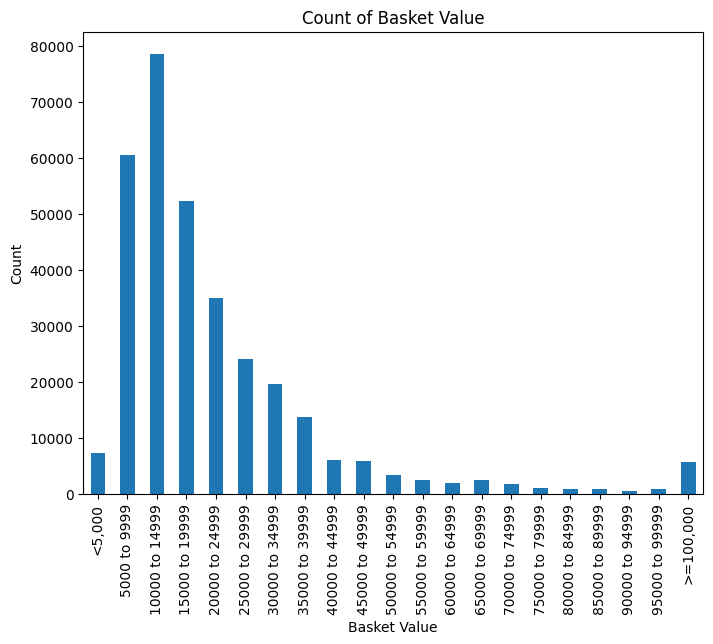

In [34]:
# Plot bar chart
grouped_data_total['count'].plot(kind='bar', figsize=(8, 6))
plt.xlabel('Basket Value')
plt.ylabel('Count')
plt.title('Count of Basket Value')
plt.show()

In [15]:
# Apply string slicing to create new columns 'StoreID' and 'BusinessDate'
new_df['StoreID'] = new_df.index.map(lambda x: x[:6])
new_df['BusinessDate'] = new_df.index.map(lambda x: x[8:14])

# Reorder the columns
new_df = new_df.reindex(columns=['StoreID', 'BusinessDate', 'Barcode', 'Sum of Qty', 'Total Exclude VAT', 'SubCategory Name'])

# Show the first 5 rows
new_df.head(5)

,StoreID,BusinessDate,Barcode,Sum of Qty,Total Exclude VAT,SubCategory Name
InvoiceID,,,,,,
VN0001010101230001,VN0001,010123,8935049500544,1,6481.0,Mineral water
VN0001010101230002,VN0001,010123,8938512632025,2,11112.0,Purified water
VN0001010101230003,VN0001,010123,"8936011773416, 8936079121761, 8850453017528, 8...",5,106482.0,"Other Ice Cream, Potato Snacks, Stick, UHT Mil..."
VN0001010101230004,VN0001,010123,"8801100128845, 2010101000005, 2010805000295, 8...",6,174478.0,"Distilled Spirits, Cup Of Ice, Add-on item Sub..."
VN0001010101230005,VN0001,010123,"8934588843051, 8934588183133",2,24074.0,"Sports Drinks Sub, Sports Drinks Sub"


In [16]:
# Calculate the ADS for each store
grouped_by_store_net = new_df.groupby('StoreID').agg({'Total Exclude VAT': 'sum', 'Sum of Qty': 'sum', 'BusinessDate': 'nunique'})
grouped_by_store_net['ADS'] = grouped_by_store_net['Total Exclude VAT'] / grouped_by_store_net['BusinessDate']
grouped_by_store_net

,Total Exclude VAT,Sum of Qty,BusinessDate,ADS
StoreID,,,,
VN0001,37069194.0,2201,2,18534597.0
VN0002,54887716.0,2455,2,27443858.0
VN0003,54329466.0,3001,2,27164733.0
VN0005,52771327.0,3062,2,26385663.5
VN0006,64483605.0,3325,2,32241802.5
...,...,...,...,...
VN0232,17126740.0,1050,2,8563370.0
VN0233,15818640.0,865,2,7909320.0
VN0234,19090178.0,1126,2,9545089.0


In [36]:
# StoreID and BusinessDate added to the filter dataframe
df_filtered['StoreID'] = df_filtered['InvoiceID'].apply(lambda x: x[:6])
df_filtered['BusinessDate'] = df_filtered['InvoiceID'].apply(lambda x: x[8:14])

# Group by Basket Value and StoreID and calculate count and mean
grouped_data_store = df_filtered.groupby(['Basket Value', 'StoreID']).agg({'InvoiceID': 'count', 'Total Exclude VAT': 'mean'})
grouped_data_store.rename(columns={'InvoiceID': 'count', 'Total Exclude VAT': 'mean'}, inplace=True)
grouped_data_store.reset_index(inplace=True)

# Calculate the 'value' column as the product of 'mean' and 'count'
grouped_data_store['Value'] = grouped_data_store['mean'] * grouped_data_store['count']

# Remove rows with count=0
grouped_data_store = grouped_data_store.query('count != 0')

# Remove rows with NaN values in 'Value' column
grouped_data_store.dropna(subset=['Value'], inplace=True)

# Reset index
grouped_data_store.reset_index(drop=True, inplace=True)

# Show the updated DataFrame
print(grouped_data_store)

C:\Users\trieu.pham\AppData\Local\Temp\ipykernel_6792\3546372196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['StoreID'] = df_filtered['InvoiceID'].apply(lambda x: x[:6])
C:\Users\trieu.pham\AppData\Local\Temp\ipykernel_6792\3546372196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['BusinessDate'] = df_filtered['InvoiceID'].apply(lambda x: x[8:14])


     Basket Value StoreID  count           mean      Value
0          <5,000  VN0001     78    3650.717949   284756.0
1          <5,000  VN0002     29    2821.034483    81810.0
2          <5,000  VN0003     91    3303.021978   300575.0
3          <5,000  VN0005     72    3171.708333   228363.0
4          <5,000  VN0006     62    3230.161290   200270.0
...           ...     ...    ...            ...        ...
4114    >=100,000  VN0232      7  161168.857143  1128182.0
4115    >=100,000  VN0233     10  130527.800000  1305278.0
4116    >=100,000  VN0234      6  123215.500000   739293.0
4117    >=100,000  VN0235     12  143524.333333  1722292.0
4118    >=100,000  VN0236     18  141202.611111  2541647.0

[4119 rows x 5 columns]
